# Intro

<img width=600 src="images/buick_skylark.jpeg">
<p>This notebook demonstrates solving a regression problem on the example of the <a href="https://archive.ics.uci.edu/ml/datasets/auto+mpg">Auto MPG Data Set</a>. MPG (miles per gallon) is a measure of cars' fuel efficiency. The dataset provides MPG values for different cars alongside with their other specs like acceleration and weight, so we can train a model to predict MPG based on these specs.</p>

# Import dependencies

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import time

import sys
sys.path.insert(0, "..")
import mymllib

%matplotlib inline
sns.set(font_scale=1.2)

# Exploratory data analysis

## Download the dataset

In [2]:
columns = ["MPG", "Cylinders", "Displacement", "Horsepower",
           "Weight", "Acceleration", "Model Year", "Origin", "Name"]
dataset = pd.read_table(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data",
    names=columns, sep="\s+", na_values = "?")
dataset.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin,Name
0,18.0,8,307.0,130.0,3504.0,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165.0,3693.0,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150.0,3436.0,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150.0,3433.0,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140.0,3449.0,10.5,70,1,ford torino


## Remove examples with missing data

As we can see, there are 6 cars in the dataset with missing data about their horsepower:

In [3]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
Name            0
dtype: int64

Since the number of the cars with missing data is small and the goal of this notebook is to showcase usage of the library rather than to build a perfect MPG prediction model, we can just drop these rows without trying to handle missing values:

In [4]:
dataset = dataset.dropna()

## Select features and target

We select MPG as the target value and all other columns (except the name) as features:

In [5]:
target_column = columns[0]
feature_columns = columns[1:-1]

print("Target:", target_column)
print("Features:", feature_columns)

Target: MPG
Features: ['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration', 'Model Year', 'Origin']


## Target's distribution

Let's plot the distribution of MPG values:

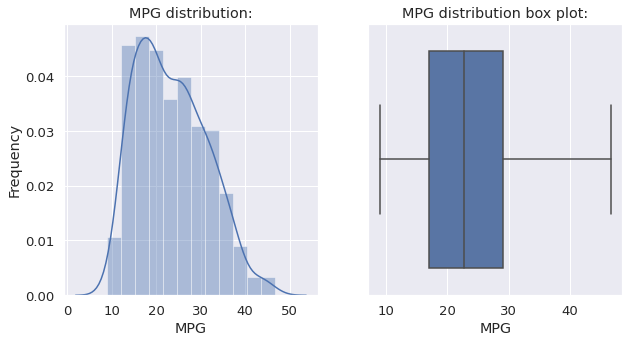

In [6]:
plt.figure(figsize=(10, 5))

plt.subplot(121)
plt.title("MPG distribution:")
sns.distplot(dataset[target_column])
plt.xlabel("MPG")
plt.ylabel("Frequency")

plt.subplot(122)
plt.title("MPG distribution box plot:")
sns.boxplot(dataset[target_column])
_ = plt.xlabel("MPG")

As plots above show, the distribution of the target value has some positive skewness. To verify this, let's calculate the exact skewness value:

In [7]:
scipy.stats.skew(dataset[target_column])

0.45534138282810366

Let's also calculate some other statistics of the target value distribution:

In [8]:
dataset[target_column].describe()

count    392.000000
mean      23.445918
std        7.805007
min        9.000000
25%       17.000000
50%       22.750000
75%       29.000000
max       46.600000
Name: MPG, dtype: float64

As we can see, the target value (MPG) ranges from 9 to 46 with the mean equal to 23.45 and the standard deviation equal to 7.81. There are no outliers, however the distribution of the target value is positively skewed.

## Correlations

Let's see how the target value depends on each of the features:

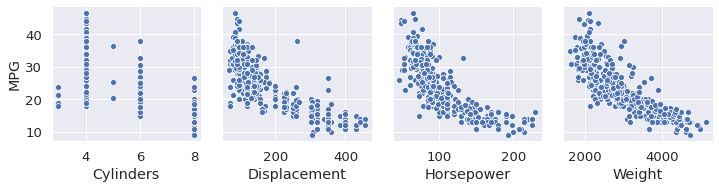

In [9]:
_ = sns.pairplot(dataset, y_vars=target_column, x_vars=feature_columns[:4])

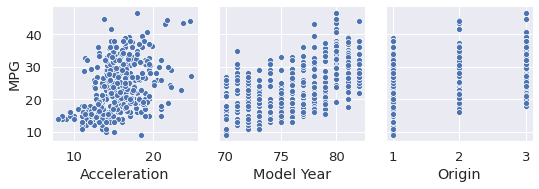

In [10]:
_ = sns.pairplot(dataset, y_vars=target_column, x_vars=feature_columns[4:])

The correlations look as expected, for instance, higher weight of a car means higher fuel consumption. What should be noted is that the correlations are not exactly linear, so to capture them we'll need to use models like linear regression with polynomial features or a neural network with at least one hidden layer.

# Models

## Train/Test split

Here we use a simple 80%/20% train/test split:

In [11]:
train_dataset = dataset.sample(frac=0.8)
test_dataset = dataset.drop(train_dataset.index)

train_x = train_dataset[feature_columns]
train_y = train_dataset[target_column]

test_x = test_dataset[feature_columns]
test_y = test_dataset[target_column]

## Linear regression

As were shown above, dependencies between the features and the target are non-linear and thus for linear regression to capture them we need to create polynomial features:

In [12]:
train_x_poly = mymllib.preprocessing.add_polynomial(train_x, 2)
test_x_poly = mymllib.preprocessing.add_polynomial(test_x, 2)

Since features are scaled differently (like acceleration and weight), we normalize the data so that all features would have a mean of 0 and a variance of 1:

In [13]:
data_scaler = mymllib.preprocessing.DataScaler().fit(train_x_poly)
train_x_norm = data_scaler.scale(train_x_poly)
test_x_norm = data_scaler.scale(test_x_poly)

Now we can train the model:

In [14]:
linear_regression = mymllib.regression.LinearRegression(
    regularization_param=0.1)
linear_regression.fit(train_x_norm, train_y)

Lets test the model's performance both on train and test sets. Mean absolute error (MAE) and mean absolute percentage error (MAPE) are used as metrics:

In [15]:
import mymllib.metrics.regression as metrics

def test_model(model, train_x, train_y, test_x, test_y):
    train_y_pred = model.predict(train_x)
    test_y_pred = model.predict(test_x)
    
    print("Train MAE:", metrics.mean_absolute_error(
        train_y, train_y_pred))
    print("Test MAE:", metrics.mean_absolute_error(
        test_y, test_y_pred))
    
    print()
    
    print("Train MAPE:", metrics.mean_absolute_percentage_error(
        train_y, train_y_pred))
    print("Test MAPE:", metrics.mean_absolute_percentage_error(
        test_y, test_y_pred))

test_model(linear_regression, train_x_norm, train_y, test_x_norm, test_y)

Train MAE: 1.834173259589095
Test MAE: 2.009741004763058

Train MAPE: 7.720330757362925
Test MAPE: 8.953469987758394


## Neural network

We will use a neural network with a hidden layer to capture non-linear dependencies, so we can skip creating polynomial features and just perform normalization:

In [16]:
data_scaler = mymllib.preprocessing.DataScaler().fit(train_x)
train_x_norm = data_scaler.scale(train_x)
test_x_norm = data_scaler.scale(test_x)

Here we train and test a feed-forward fully-connected neural network with a single hidden layer:

In [17]:
neural_net = mymllib.neural_networks.RegressionNeuralNetwork(
    hidden_layers=(4,),
    regularization_param=0.1)
neural_net.fit(train_x_norm, train_y)
test_model(neural_net, train_x_norm, train_y, test_x_norm, test_y)

Train MAE: 1.7564415578182848
Test MAE: 1.9826434075015935

Train MAPE: 7.483531971496172
Test MAPE: 8.87978906627254
